# European Develompent Indicators - Iceland

## Research Questions

1. How has Iceland's GDP growth correlated with inflation rates over the past 20 years?

2. What is the relationship between educational attainment and unemployment in Iceland?

3. What is the gender wage gap trend in Iceland, and how does it compare with female employment rates?

## Datasets

* [namq_10_gdp](https://doi.org/10.2908/NAMQ_10_GDP) - Eurostat: Quarterly GDP

* [nama_10_co3_p3](https://doi.org/10.2908/NAMA_10_CO3_P3) - Eurostat: Annual household disposable income

* [tec00001](https://doi.org/10.2908/TEC00001) - Eurostat: Annual GDP at market prices

* [prc_hicp_midx](https://doi.org/10.2908/PRC_HICP_MIDX) - Eurostat: Monthly Harmonized CPI

* [prc_hicp_manr](https://doi.org/10.2908/PRC_HICP_MANR) - Eurostat: Monthly CPI inflation rate

* [prc_hicp_inw](https://doi.org/10.2908/PRC_HICP_INW) - Eurostat: Annual CPI inflation rate by income group

* [lfsa_urgaed](https://doi.org/10.2908/LFSA_URGAED) - Eurostat: Annual unemployment rate by education level

* [lfsa_egaed](https://doi.org/10.2908/LFSA_EGAED) - Eurostat: Annual employment rate by education level

* [lfsa_egised](https://doi.org/10.2908/LFSA_EGISED) - Eurostat: Annual employed persons by occupation and educational attainment level

* [lfsa_egan](https://doi.org/10.2908/LFSA_EGAN) - Eurostat: Annual employment

* [lfsi_emp_q](https://doi.org/10.2908/LFSI_EMP_Q) - Eurostat: Quarterly employment and activity by sex and age

* [lfsi_long_q](https://doi.org/10.2908/LFSI_LONG_Q) - Eurostat: Quarterly labour market transitions

* [lfsq_ergan](https://doi.org/10.2908/LFSQ_ERGAN) - Eurostat: Quarterly employment rates by citizenship

* [une_rt_m](https://doi.org/10.2908/UNE_RT_M) - Eurostat: Monthly total unemployment rate

* [edat_lfse_03](https://doi.org/10.2908/EDAT_LFSE_03) - Eurostat: Annual population by educational attainment level

* [earn_nt_net](https://doi.org/10.2908/EARN_NT_NET) - Eurostat: Annual net earnings

* [earn_gr_gpgr2](https://doi.org/10.2908/EARN_GR_GPGR2) - Eurostat: Annual gender pay gap in unadjusted form


# Definitions

#### `s_adj` — Seasonal Adjustment

| Code  | Meaning                            |
| ----- | ---------------------------------- |
| `SCA` | Seasonal & calendar adjusted       |
| `NSA` | Not seasonally adjusted            |


#### `na_item` — National Accounts Item

| Code   | Meaning                                                           |
| ------ | ----------------------------------------------------------------- |
| `B1GQ` | Gross Domestic Product (GDP), volume, chain-linked, market prices |


#### `unit` — Unit of Measure
| Code         | Meaning                              |
| ------------ | ------------------------------------ |
| `CLV10_MEUR` | Chain linked volumes, base year 2010 |


#### `coicop` — Consumption Purpose Categories

| Code   | Meaning        |
| ------ | -------------- |
| `CP00` | All-items HICP |



## Imports

In [418]:
import os
from typing import Literal

import eurostat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [419]:
COUNTRY_NAME = "Iceland"
COUNTRY_CODE = "IS"

ORIGINAL_DATA_DIR = "original_data"
EVENTS = [
    {
        "name": "2008 Financial Crisis",
        "year": "2008",
        "positive": False
    },
    {
        "name": "EU Membership Application",
        "year": "2009",
        "positive": True
    },
    {
        "name": "Volcanic Eruption Eyjafjallajökull",
        "year": "2010",
        "positive": False
    },
    {
        "name": "Volcanic Eruption Grímsvötn",
        "year": "2011",
        "positive": False
    },
    {
        "name": "COVID-19 Pandemic",
        "year": "2020",
        "positive": False
    }
]
DATAFRAME_INFO: dict[pd.DataFrame, dict[str, str]] = {}

In [420]:
def get_dataframe(eurostat_code: str, country_code: str = COUNTRY_CODE) -> pd.DataFrame:
    file_path = os.path.join(ORIGINAL_DATA_DIR, f"{eurostat_code}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

    else:
        df = eurostat.get_data_df(eurostat_code)
        os.makedirs(ORIGINAL_DATA_DIR, exist_ok=True)
        df.to_csv(file_path, index=False)

    df = df[df["geo\\TIME_PERIOD"] == country_code]
    df.rename(columns={"geo\\TIME_PERIOD": "geo"}, inplace=True)

    return df


In [421]:
def fix_dates(src_df: pd.DataFrame) -> pd.DataFrame:
    df = src_df.copy()

    column_names = df.columns.tolist()
    time_period_index = column_names.index("geo")
    data_columns = column_names[time_period_index + 1 :]

    if df["freq"].iloc[0] == "M":
        df.rename(columns={col: f"{col[:4]}-{col[5:7]}-01" for col in data_columns}, inplace=True)
    elif df["freq"].iloc[0] == "Q":
        df.rename(columns={col: f"{col[:4]}-{(int(col[6]) - 1) * 3 + 1:02d}-01" for col in data_columns}, inplace=True)
    elif df["freq"].iloc[0] == "A":
        df.rename(columns={col: f"{col}-01-01" for col in data_columns}, inplace=True)

    return df


In [422]:
def remove_empty_columns(src_df: pd.DataFrame) -> pd.DataFrame:
    df = src_df.copy()
    df.dropna(axis=1, how="all", inplace=True)

    return df


In [423]:
def melt_dataframe(
    src_df: pd.DataFrame,
) -> pd.DataFrame:
    column_names = src_df.columns.tolist()
    time_period_index = column_names.index("geo")
    data_columns = column_names[time_period_index + 1 :]
    id_cols = column_names[: time_period_index + 1]

    df_melted = src_df.melt(id_vars=id_cols, value_vars=data_columns, var_name="time", value_name="value")
    df_melted = df_melted.drop(columns=["geo"])
    df_melted = df_melted.dropna(subset=["value"])
    df_melted["value"] = pd.to_numeric(df_melted["value"], errors="coerce")

    return df_melted


In [424]:
def drop_columns(src_df: pd.DataFrame, columns_to_drop: list[str]) -> pd.DataFrame:
    df = src_df.copy()
    df.drop(columns=columns_to_drop, inplace=True)

    return df


In [425]:
def filter_dataframe(src_df: pd.DataFrame, filter: dict[str, list[str]]) -> pd.DataFrame:
    df = src_df.copy()

    for column, values in filter.items():
        df = df[df[column].isin(values)]

    return df


In [426]:
def get_unique_values(src_df: pd.DataFrame) -> dict[str, list[str]]:
    df = src_df.copy()
    df = df.drop(columns=["time", "value"]).drop_duplicates()

    unique_values = {col: df[col].unique().tolist() for col in df.columns}

    return unique_values


In [427]:
def make_histogram(
    src_df: pd.DataFrame,
    bins: Literal["auto", "sturges", "fd", "doane", "scott", "rice", "sqrt"] = "auto",
) -> plt.Figure:
    df = src_df.copy()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x="value", bins=bins, kde=True)

    plt.title(f"Histogram of {src_df.title}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)

    return plt


In [428]:
def make_line_plot(
    src_df: pd.DataFrame,
) -> plt.Figure:
    df = src_df.copy()
    df["time"] = pd.to_datetime(df["time"])

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="time", y="value")

    for event in EVENTS:
        plt.axvline(pd.to_datetime(f"{event['year']}-01-01"), color='blue' if event['positive'] else 'red', linestyle='--', alpha=0.7)
        plt.text(pd.to_datetime(f"{event['year']}-01-01"), plt.ylim()[1]*0.9, event['name'], rotation=90, verticalalignment='center', color='blue' if event['positive'] else 'red')

    plt.title(f"Line Plot of {src_df.title}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

    return plt


In [429]:
def make_combined_line_plot(
    src_df_1: pd.DataFrame,
    src_df_2: pd.DataFrame
) -> plt.Figure:
    df1 = src_df_1.copy()
    df2 = src_df_2.copy()
    df1["time"] = pd.to_datetime(df1["time"])
    df2["time"] = pd.to_datetime(df2["time"])

    fig, ax1 = plt.subplots(figsize=(12, 6))
    color1 = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel(f'{src_df_1.title}', color=color1)
    ax1.plot(df1['time'], df1['value'], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel(f'{src_df_2.title}', color=color2)
    ax2.plot(df2['time'], df2['value'], color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    plt.title(f"Combined Line Plot of {src_df_1.title} and {src_df_2.title}")
    fig.tight_layout()

    for event in EVENTS:
        plt.axvline(pd.to_datetime(f"{event['year']}-01-01"), color='blue' if event['positive'] else 'red', linestyle='--', alpha=0.7)
        plt.text(pd.to_datetime(f"{event['year']}-01-01"), plt.ylim()[1]*0.9, event['name'], rotation=90, verticalalignment='center', color='blue' if event['positive'] else 'red')

    return plt

In [430]:
def make_scatter_plot(
    src_df: pd.DataFrame,
) -> plt:
    df = src_df.copy()
    df["time"] = pd.to_datetime(df["time"])

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x="time", y="value")

    for event in EVENTS:
        plt.axvline(pd.to_datetime(f"{event['year']}-01-01"), color='blue' if event['positive'] else 'red', linestyle='--', alpha=0.7)
        plt.text(pd.to_datetime(f"{event['year']}-01-01"), plt.ylim()[1]*0.9, event['name'], rotation=90, verticalalignment='center', color='blue' if event['positive'] else 'red')

    plt.title(f"Scatter Plot of {src_df.title}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

    return plt


In [431]:
def make_box_plot(
    src_df: pd.DataFrame,
) -> plt.Figure:
    df = src_df.copy()
    df["time"] = pd.to_datetime(df["time"])

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=df["value"])
    plt.xlabel("Value")
    plt.title(f"Box Plot of {src_df.title}")

    return plt

In [432]:
def make_correlation_heatmap(
    dataframes: list[pd.DataFrame],
) -> plt.Figure:
    combined_df = pd.DataFrame()

    for df in dataframes:
        temp_df = df.copy()
        temp_df["time"] = pd.to_datetime(temp_df["time"])
        temp_df.set_index("time", inplace=True)
        temp_df = temp_df.rename(columns={"value": df.name})
        combined_df = pd.concat([combined_df, temp_df[df.name]], axis=1)

    correlation_matrix = combined_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap")

    return plt



In [433]:
def make_combined_bar_plot(
    src_df_1: pd.DataFrame,
    src_df_2: pd.DataFrame
) -> plt.Figure:
    df1 = src_df_1.copy()
    df2 = src_df_2.copy()
    df1["time"] = pd.to_datetime(df1["time"])
    df2["time"] = pd.to_datetime(df2["time"])

    width = (df1['time'].max() - df1['time'].min()).days / len(df1) * 0.5

    fig, ax1 = plt.subplots(figsize=(12, 6))
    color1 = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel(f'{src_df_1.title}', color=color1)
    ax1.bar(df1['time'], df1['value'], color=color1, alpha=0.7, width=width, align='center')
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel(f'{src_df_2.title}', color=color2)
    ax2.bar(df2['time'], df2['value'], color=color2, alpha=0.7, width=width, align='edge')
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

    for event in EVENTS:
        plt.axvline(pd.to_datetime(f"{event['year']}-01-01"), color='blue' if event['positive'] else 'red', linestyle='--', alpha=0.7)
        plt.text(pd.to_datetime(f"{event['year']}-01-01"), plt.ylim()[1]*0.9, event['name'], rotation=90, verticalalignment='center', color='blue' if event['positive'] else 'red')

    plt.title(f"Combined Bar Plot of {src_df_1.title} and {src_df_2.title}")
    fig.tight_layout()

    return plt

In [434]:
def get_change_rates(
    src_df: pd.DataFrame,
) -> pd.DataFrame:
    df = src_df.copy()
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values(by="time")
    df["value"] = df["value"].pct_change() * 100

    return df

In [435]:
def combine_to_yearly(
    src_df: pd.DataFrame,
) -> pd.DataFrame:
    df = src_df.copy()
    df = df[["time", "value"]]
    df = df.set_index("time")
    df_yearly = df.resample("YE").mean().reset_index()
    df_yearly["time"] = df_yearly["time"].dt.year.astype(str)

    return df_yearly

In [436]:
def get_opposite_trend_data(
    src_df: pd.DataFrame,
) -> pd.DataFrame:
    df = src_df.copy()
    df["value"] = -df["value"]

    return df

# How has Iceland's GDP growth correlated with inflation rates over the past 20 years?

## Datasets:

* [namq_10_gdp](https://doi.org/10.2908/NAMQ_10_GDP) - Eurostat: Quarterly GDP

* [nama_10_co3_p3](https://doi.org/10.2908/NAMA_10_CO3_P3) - Eurostat: Annual household disposable income

* [tec00001](https://doi.org/10.2908/TEC00001) - Eurostat: Annual GDP at market prices

* [prc_hicp_midx](https://doi.org/10.2908/PRC_HICP_MIDX) - Eurostat: Monthly Harmonized CPI

* [prc_hicp_manr](https://doi.org/10.2908/PRC_HICP_MANR) - Eurostat: Monthly CPI inflation rate

* [prc_hicp_inw](https://doi.org/10.2908/PRC_HICP_INW) - Eurostat: Annual CPI inflation rate by income group


### namq_10_gdp -- Quarterly GDP

`CLV10_MEUR` — Chain linked volumes, base year 2010

`B1GQ` — Gross Domestic Product (GDP), volume, chain-linked, market prices

`SCA` — Seasonally & calendar adjusted


,unit,s_adj,na_item,time,value
95,CLV10_MEUR,SCA,B1GQ,1995-01-01,1578.1
1290,CLV10_MEUR,SCA,B1GQ,1995-04-01,1610.4
2485,CLV10_MEUR,SCA,B1GQ,1995-07-01,1625.4
3680,CLV10_MEUR,SCA,B1GQ,1995-10-01,1613.9
4875,CLV10_MEUR,SCA,B1GQ,1996-01-01,1671.2


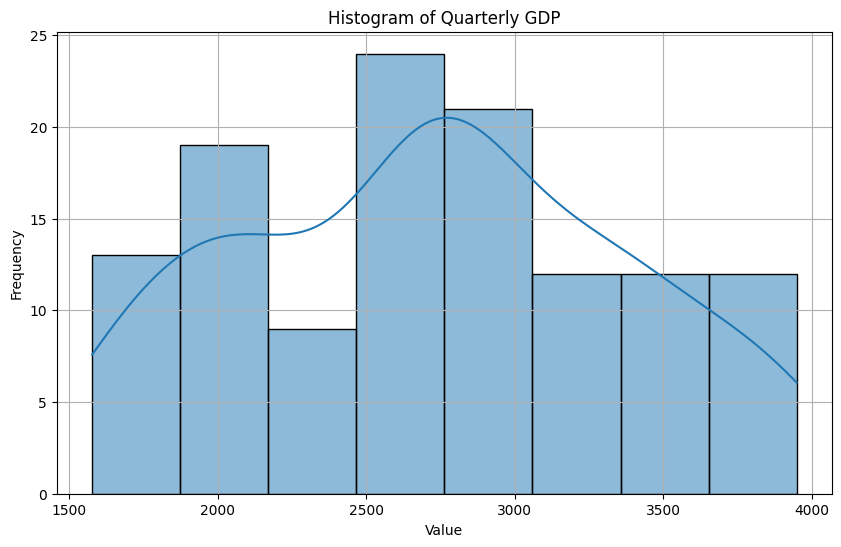

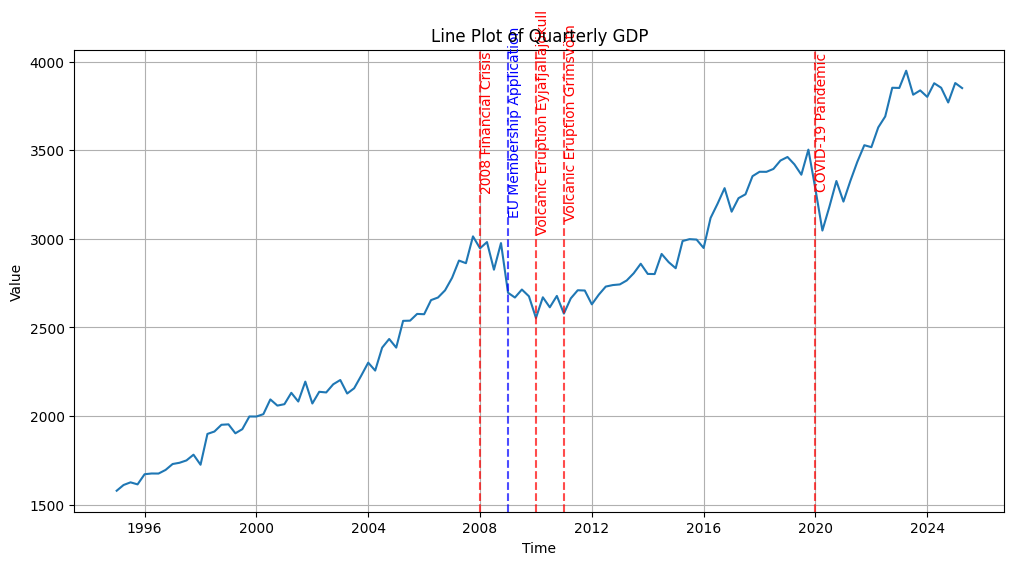

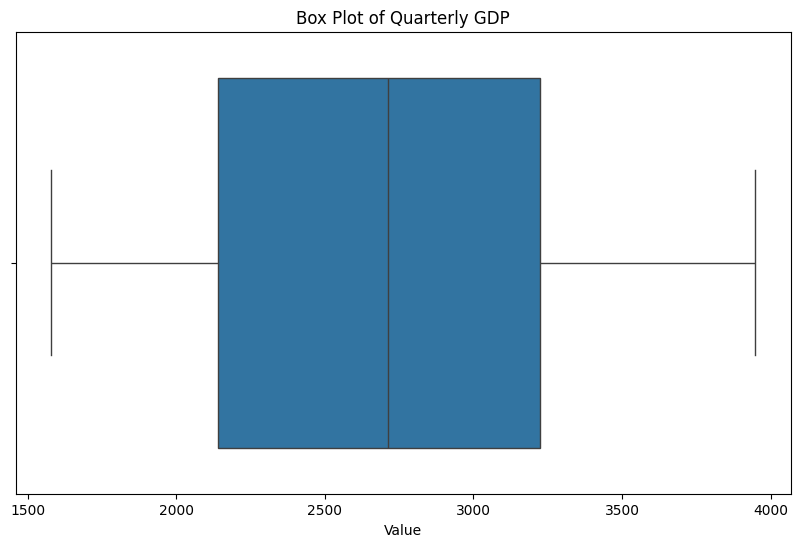

In [437]:
namq_10_gdp = get_dataframe("namq_10_gdp")
namq_10_gdp = fix_dates(namq_10_gdp)
namq_10_gdp = remove_empty_columns(namq_10_gdp)
namq_10_gdp = melt_dataframe(namq_10_gdp)
namq_10_gdp = drop_columns(namq_10_gdp, ["freq"])
namq_10_gdp = filter_dataframe(namq_10_gdp, {"unit": ["CLV10_MEUR"], "na_item": ["B1GQ"], "s_adj": ["SCA"]})
namq_10_gdp.name = "namq_10_gdp"
namq_10_gdp.title = "Quarterly GDP"


display(namq_10_gdp.head())
make_histogram(namq_10_gdp).show()
make_line_plot(namq_10_gdp).show()
# make_scatter_plot(namq_10_gdp).show()
make_box_plot(namq_10_gdp).show()


### nama_10_co3_p3 -- Annual Household Disposable Income

`CLV10_MEUR` — Chain linked volumes, base year 2010

`TOTAL` — Total COICOP


,unit,coicop,time,value
182,CLV10_MEUR,TOTAL,1995-01-01,3208.9
1890,CLV10_MEUR,TOTAL,1996-01-01,3369.0
3598,CLV10_MEUR,TOTAL,1997-01-01,3565.5
5306,CLV10_MEUR,TOTAL,1998-01-01,3951.3
7014,CLV10_MEUR,TOTAL,1999-01-01,4240.4


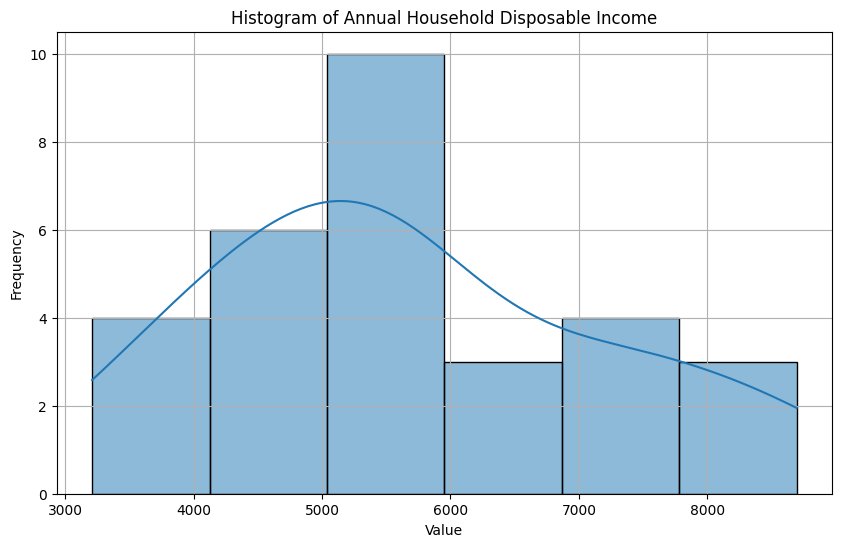

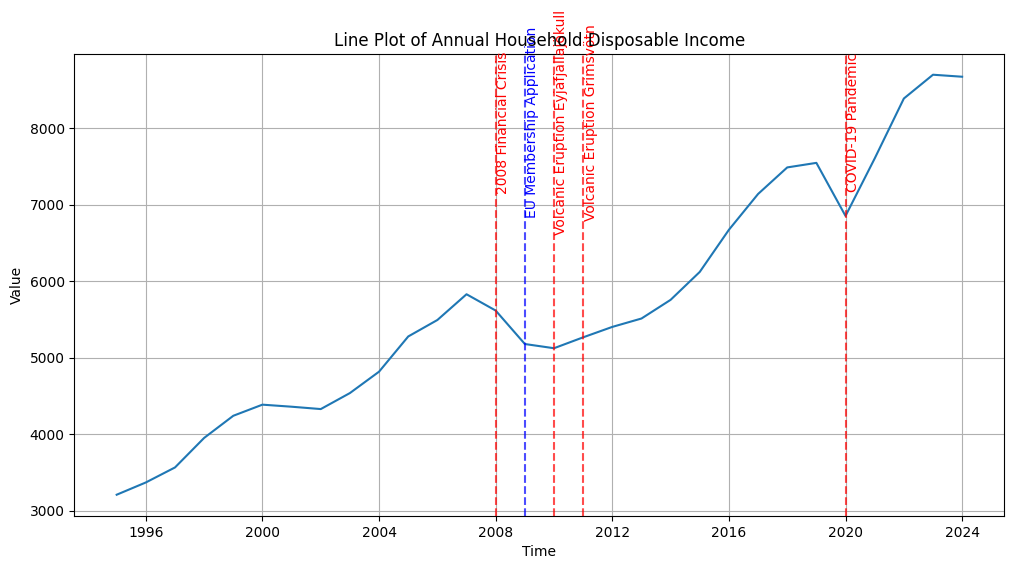

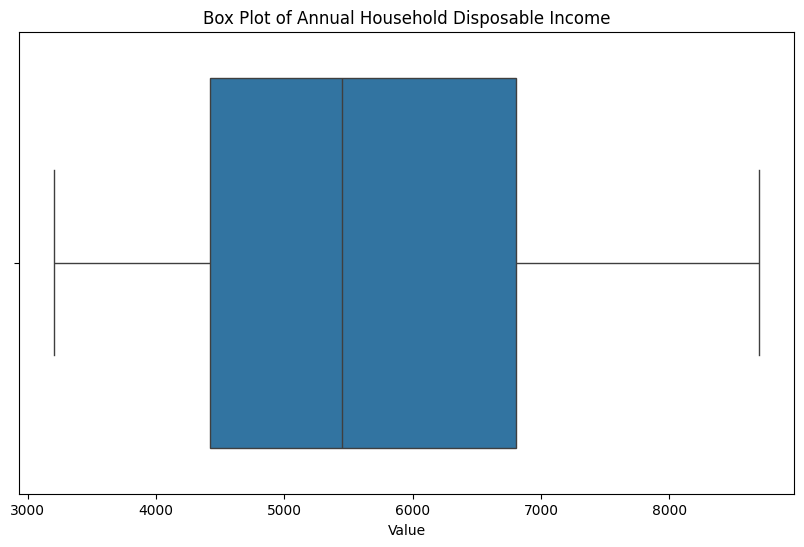

In [438]:
nama_10_co3_p3 = get_dataframe("nama_10_co3_p3")
nama_10_co3_p3 = fix_dates(nama_10_co3_p3)
nama_10_co3_p3 = remove_empty_columns(nama_10_co3_p3)
nama_10_co3_p3 = melt_dataframe(nama_10_co3_p3)
nama_10_co3_p3 = drop_columns(nama_10_co3_p3, ["freq"])
nama_10_co3_p3 = filter_dataframe(nama_10_co3_p3, {"unit": ["CLV10_MEUR"], "coicop": ["TOTAL"]})
nama_10_co3_p3.name = "nama_10_co3_p3"
nama_10_co3_p3.title = "Annual Household Disposable Income"

display(nama_10_co3_p3.head())
make_histogram(nama_10_co3_p3).show()
make_line_plot(nama_10_co3_p3).show()
# make_scatter_plot(nama_10_co3_p3).show()
make_box_plot(nama_10_co3_p3).show()


### tec00001 -- Annual GDP at Market Prices

`CP_MEUR` — Current prices, million euro

`B1GQ` — Gross Domestic Product (GDP), volume, chain-linked, market prices


,na_item,unit,time,value
1,B1GQ,CP_MEUR,2013-01-01,12222.7
3,B1GQ,CP_MEUR,2014-01-01,13611.7
5,B1GQ,CP_MEUR,2015-01-01,15960.5
7,B1GQ,CP_MEUR,2016-01-01,19067.0
9,B1GQ,CP_MEUR,2017-01-01,22211.8


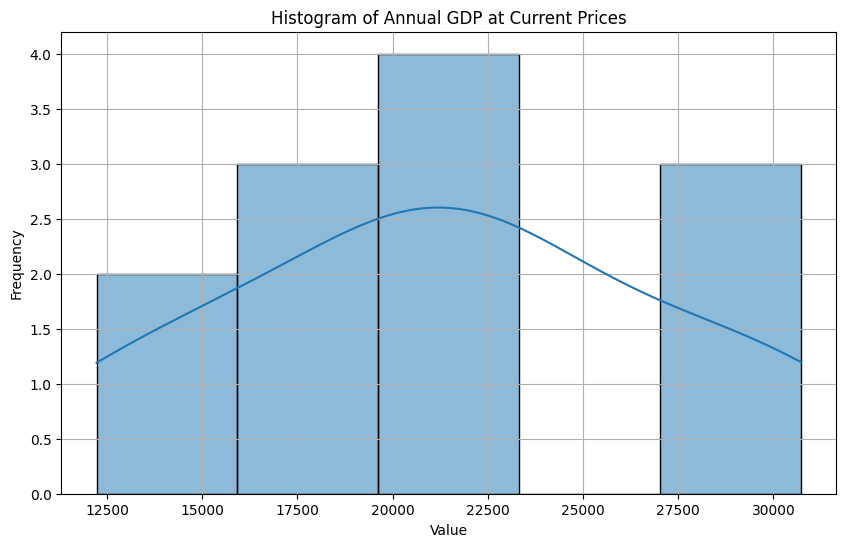

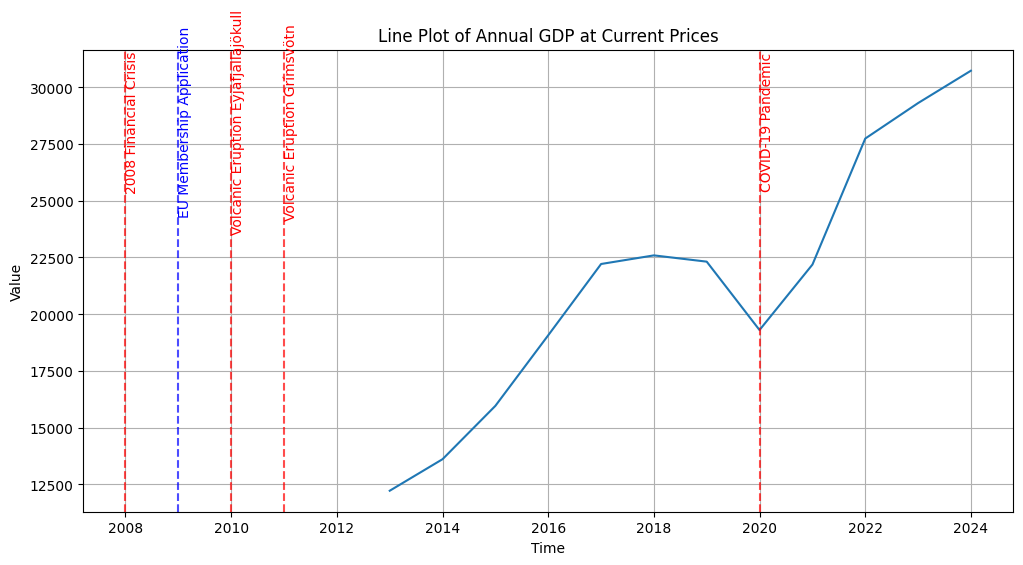

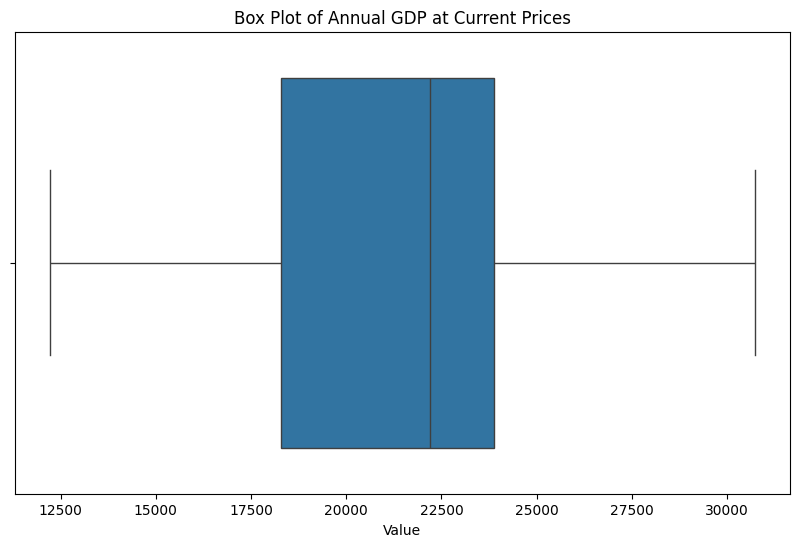

In [439]:
tec00001 = get_dataframe("tec00001")
tec00001 = fix_dates(tec00001)
tec00001 = remove_empty_columns(tec00001)
tec00001 = melt_dataframe(tec00001)
tec00001 = drop_columns(tec00001, ["freq"])
tec00001 = filter_dataframe(tec00001, {"unit": ["CP_MEUR"], "na_item": ["B1GQ"]})
tec00001.name = "tec00001"
tec00001.title = "Annual GDP at Current Prices"

display(tec00001.head())
make_histogram(tec00001).show()
make_line_plot(tec00001).show()
# make_scatter_plot(tec00001).show()
make_box_plot(tec00001).show()


### prc_hicp_midx -- Monthly Harmonized CPI

`I15` - Index, 2015

`CP00` - All-items HICP


,unit,coicop,time,value
156,I15,CP00,1996-01-01,42.75
813,I15,CP00,1996-02-01,42.83
1470,I15,CP00,1996-03-01,42.92
2127,I15,CP00,1996-04-01,43.09
2784,I15,CP00,1996-05-01,43.27


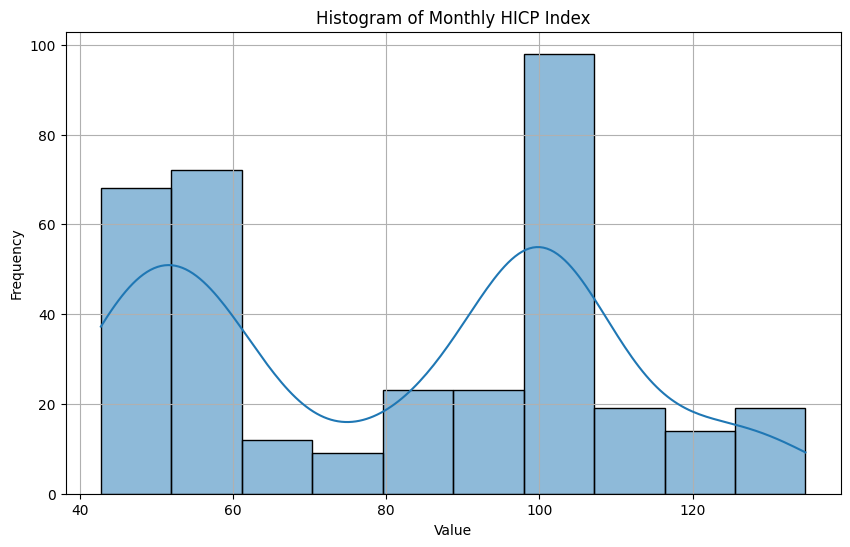

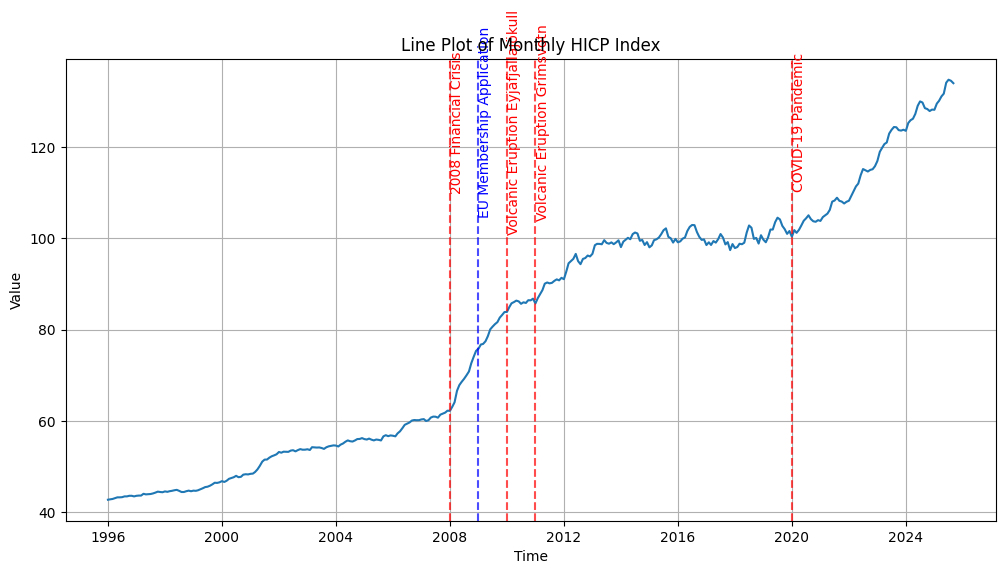

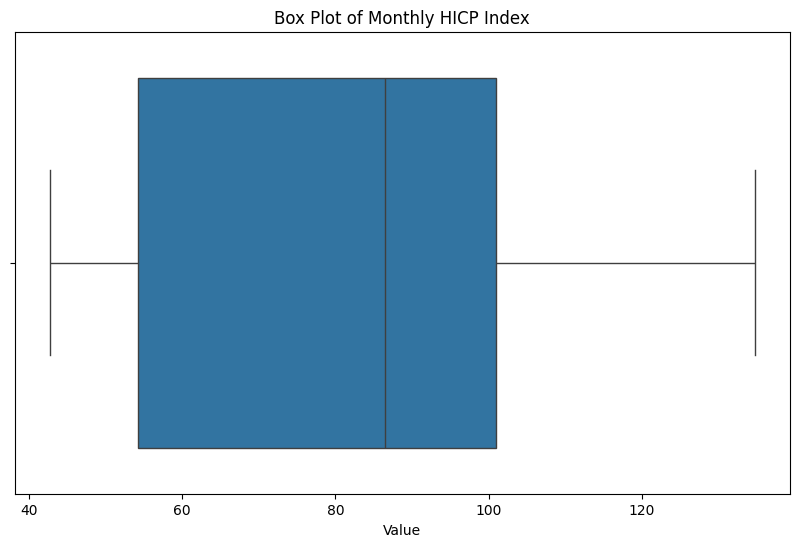

In [440]:
prc_hicp_midx = get_dataframe("prc_hicp_midx")
prc_hicp_midx = fix_dates(prc_hicp_midx)
prc_hicp_midx = remove_empty_columns(prc_hicp_midx)
prc_hicp_midx = melt_dataframe(prc_hicp_midx)
prc_hicp_midx = drop_columns(prc_hicp_midx, ["freq"])
prc_hicp_midx = filter_dataframe(prc_hicp_midx, {"unit": ["I15"], "coicop": ["CP00"]})
prc_hicp_midx.name = "prc_hicp_midx"
prc_hicp_midx.title = "Monthly HICP Index"

display(prc_hicp_midx.head())
make_histogram(prc_hicp_midx).show()
make_line_plot(prc_hicp_midx).show()
# make_scatter_plot(prc_hicp_midx).show()
make_box_plot(prc_hicp_midx).show()


### prc_hicp_manr -- Monthly CPI Inflation Rate

`RCH_A` - Annual rate of change

`CP00` - All-items HICP


,unit,coicop,time,value
0,RCH_A,CP00,1997-01-01,2.0
364,RCH_A,CP00,1997-02-01,1.9
728,RCH_A,CP00,1997-03-01,1.7
1092,RCH_A,CP00,1997-04-01,2.2
1456,RCH_A,CP00,1997-05-01,1.5


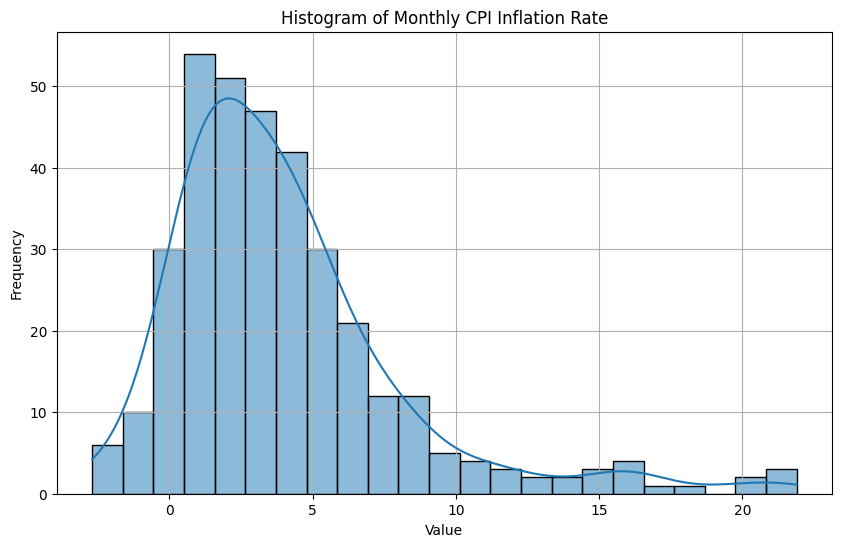

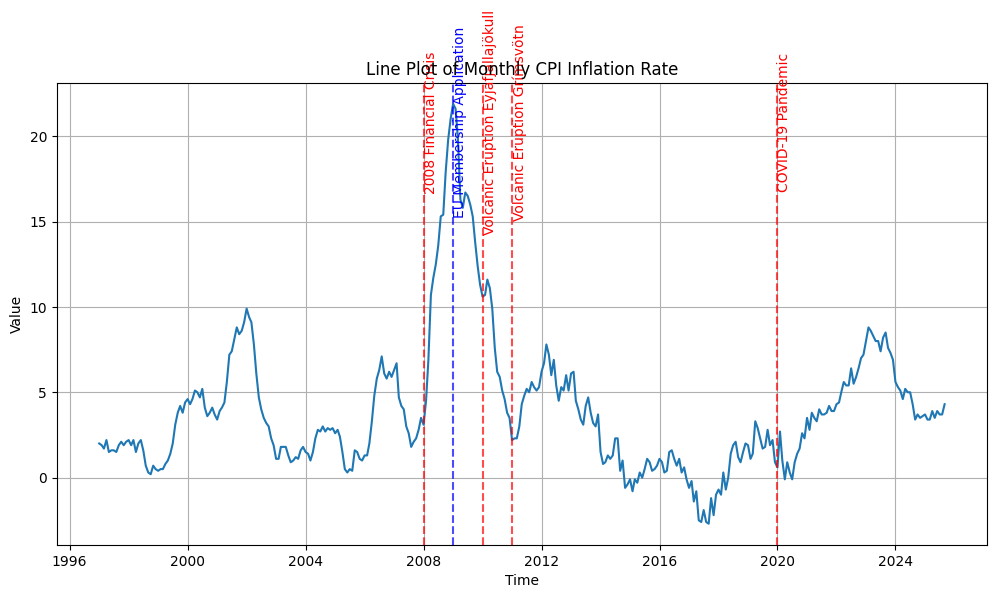

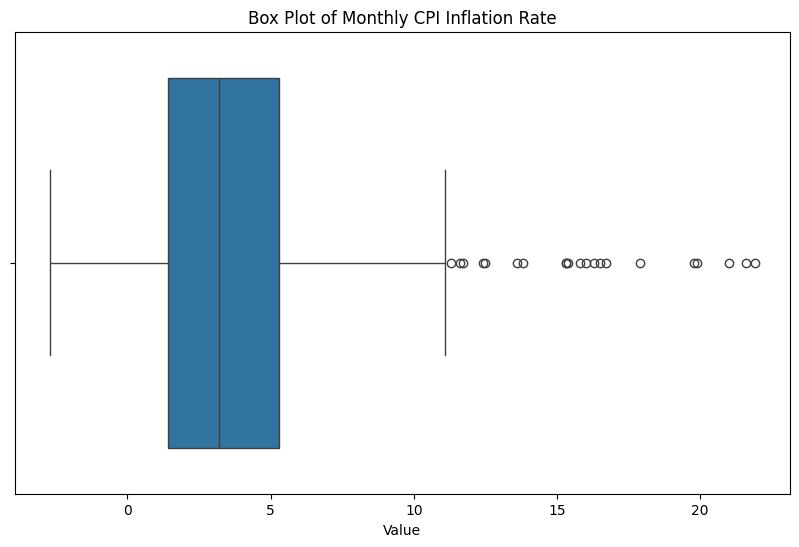

In [441]:
prc_hicp_manr = get_dataframe("prc_hicp_manr")
prc_hicp_manr = fix_dates(prc_hicp_manr)
prc_hicp_manr = remove_empty_columns(prc_hicp_manr)
prc_hicp_manr = melt_dataframe(prc_hicp_manr)
prc_hicp_manr = drop_columns(prc_hicp_manr, ["freq"])
prc_hicp_manr = filter_dataframe(prc_hicp_manr, {"unit": ["RCH_A"], "coicop": ["CP00"]})
prc_hicp_manr.name = "prc_hicp_manr"
prc_hicp_manr.title = "Monthly CPI Inflation Rate"

display(prc_hicp_manr.head())
make_histogram(prc_hicp_manr).show()
make_line_plot(prc_hicp_manr).show()
# make_scatter_plot(prc_hicp_manr).show()
make_box_plot(prc_hicp_manr).show()


### prc_hicp_inw -- Annual CPI Inflation Rate by Income Group

`CP01` - Food and non-alcoholic beverages


,coicop,time,value
3,CP01,1996-01-01,207.70
463,CP01,1997-01-01,206.60
923,CP01,1998-01-01,211.34
1383,CP01,1999-01-01,210.25
1843,CP01,2000-01-01,192.74


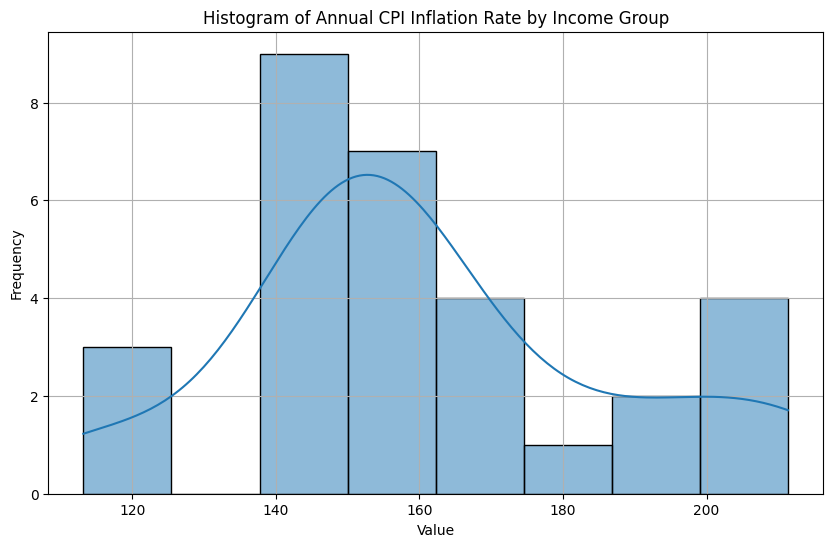

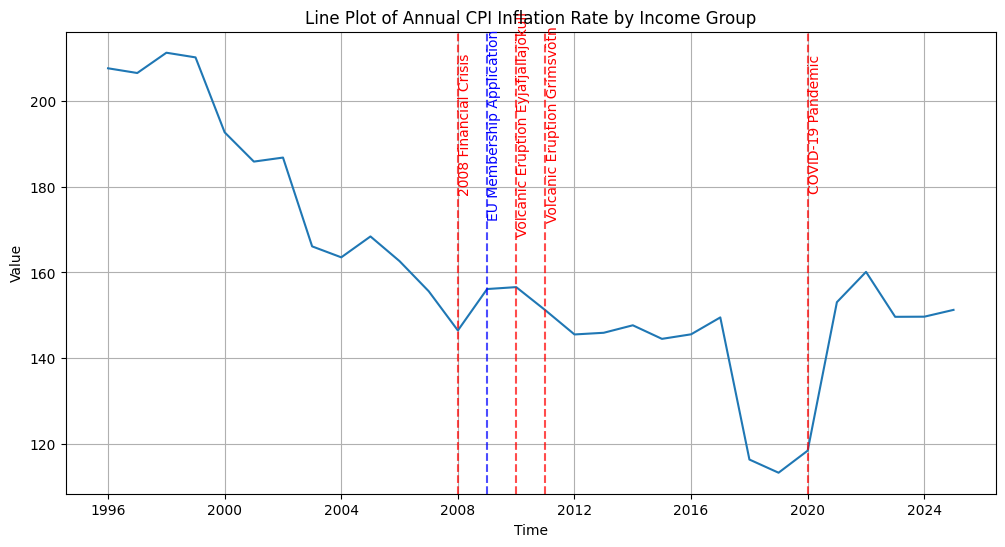

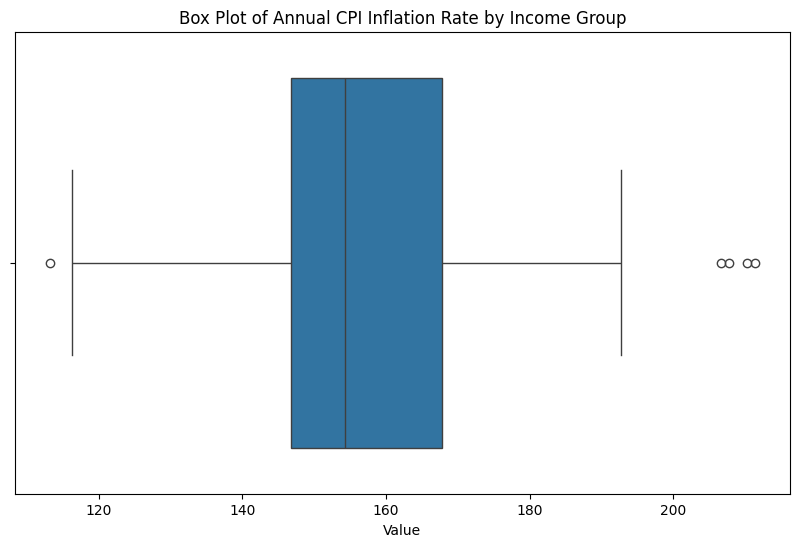

In [442]:
prc_hicp_inw = get_dataframe("prc_hicp_inw")
prc_hicp_inw = fix_dates(prc_hicp_inw)
prc_hicp_inw = remove_empty_columns(prc_hicp_inw)
prc_hicp_inw = melt_dataframe(prc_hicp_inw)
prc_hicp_inw = drop_columns(prc_hicp_inw, ["freq"])
prc_hicp_inw = filter_dataframe(prc_hicp_inw, {"coicop": ["CP01"]})
prc_hicp_inw.name = "prc_hicp_inw"
prc_hicp_inw.title = "Annual CPI Inflation Rate by Income Group"

display(prc_hicp_inw.head())
make_histogram(prc_hicp_inw).show()
make_line_plot(prc_hicp_inw).show()
# make_scatter_plot(prc_hicp_inw).show()
make_box_plot(prc_hicp_inw).show()


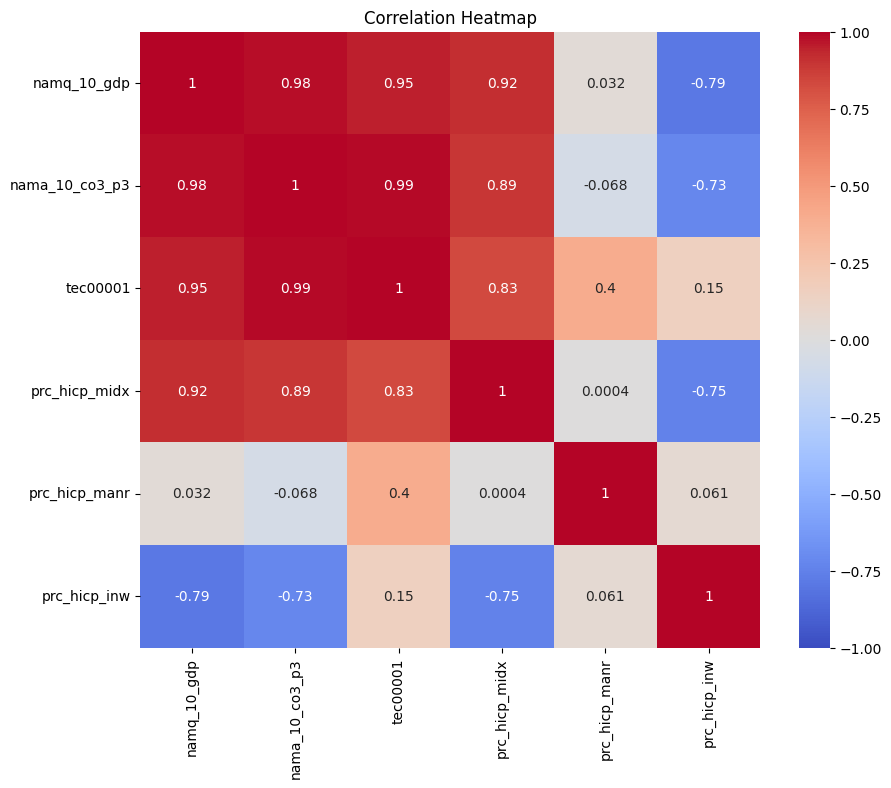

In [443]:
make_correlation_heatmap([
    namq_10_gdp,
    nama_10_co3_p3,
    tec00001,
    prc_hicp_midx,
    prc_hicp_manr,
    prc_hicp_inw
]).show()

In [444]:
display(namq_10_gdp.title)
display(nama_10_co3_p3.title)
display(tec00001.title)
display(prc_hicp_midx.title)
display(prc_hicp_manr.title)
display(prc_hicp_inw.title)

'Quarterly GDP'

'Annual Household Disposable Income'

'Annual GDP at Current Prices'

'Monthly HICP Index'

'Monthly CPI Inflation Rate'

'Annual CPI Inflation Rate by Income Group'

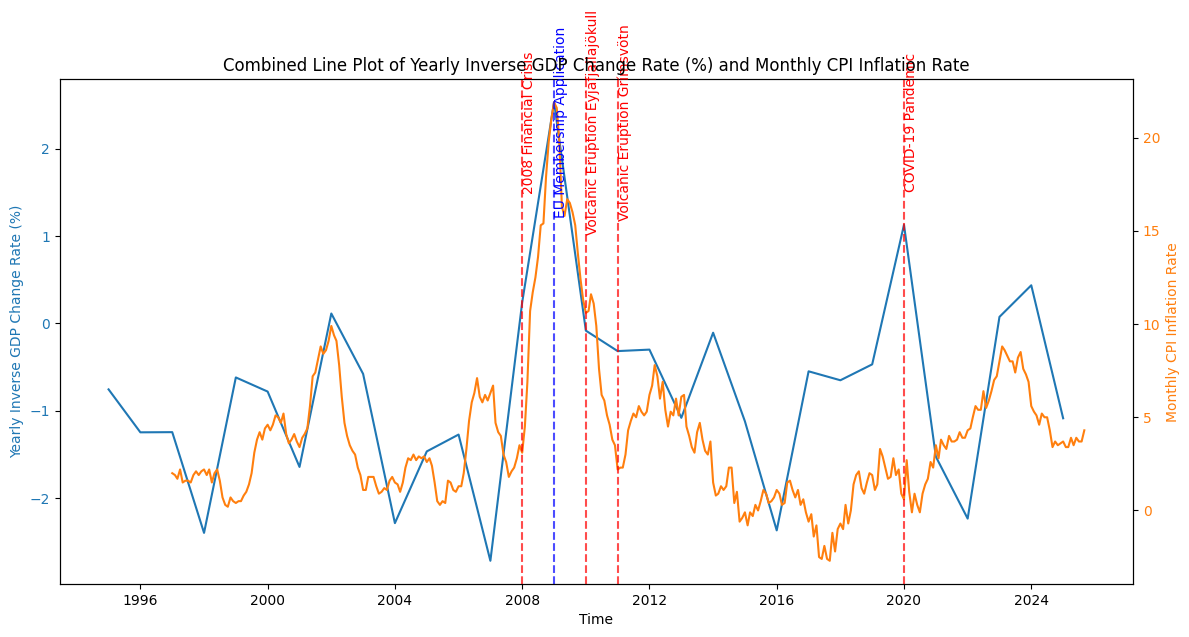

In [451]:
namq_10_gdp_changes_y = get_opposite_trend_data(combine_to_yearly(get_change_rates(namq_10_gdp)))
namq_10_gdp_changes_y.title = "Yearly Inverse GDP Change Rate (%)"

make_combined_line_plot(
    namq_10_gdp_changes_y,
    prc_hicp_manr
).show()
